In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Grid Generation Tutorial

> A basic introduction to Geospatial Grids

## Basic Usage
Creating a grid from a geojson file

In [6]:
# hide
import warnings

from IPython.display import display

warnings.filterwarnings("ignore")

### Import `geopandas` and the `geowrangler.grids` module

In [7]:
import geopandas as gpd
import pandas as pd

from geowrangler import grids

In [8]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

### Load a sample geojson file into pandas 


In our case, we are loading the Region 3 (Central Luzon Administrative Region) of the Philippines.

In [9]:
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

This geopandas dataframe has the size: 

In [10]:
# hide_input
print(f"length of region3_gdf: {len(region3_gdf)} row(s)")

length of region3_gdf: 1 row(s)


In [11]:
display(region3_gdf)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."


Show the original plot

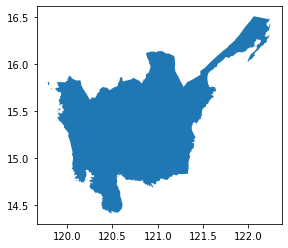

In [12]:
import matplotlib.pyplot as plt

ax = region3_gdf.plot(ax=plt.axes())

In [13]:
region3_gdf.crs  # CRS info

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
aoi_total_bounds = region3_gdf.total_bounds
aoi_total_bounds

array([119.7858332,  14.4075257, 122.2429921,  16.5092548])

## Square Grid Generator
### Creating Grids

Create a grid generator with a size of `5,000` m. 
The units of the grid size are dependent on the projection parameter  
of the grid generator. In this case, the [default is  `EPSG:3857`](https://epsg.io/3857).

In [15]:
grids.SquareGridGenerator?

Init signature:
grids.SquareGridGenerator(
    cell_size: float,
    grid_projection: str = 'EPSG:3857',
    boundary: Union[geowrangler.grids.SquareGridBoundary, List[float]] = None,
)
Docstring:      <no docstring>
File:           ~/work/ai4d/geowrangler/geowrangler/grids.py
Type:           type
Subclasses:     


In [16]:
grid_generator5k = grids.SquareGridGenerator(5_000)  # 5 km x 5 km square cells

Generate square grids
> Notice the time taken to grid the multi polygon at 5K resolution


In [17]:
%%time
# slow
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

CPU times: user 42.2 s, sys: 0 ns, total: 42.2 s
Wall time: 42.2 s


Show gridded version of sample geojson file at 5K resolution 

In [18]:
# hide_input
# no_test
print(f"length of grid_gdf5k: {len(grid_gdf5k)} row(s)")

length of grid_gdf5k: 1074 row(s)


In [19]:
# hide
# slow
assert len(grid_gdf5k) == 1074

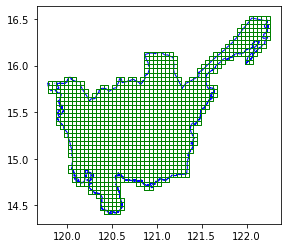

In [20]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

In addition to the grid cells, there are 2 extra columns `x` and `y` when combined are unique per grid. It can also tell us which grids are adjacent to each other. 

In [21]:
# slow
grid_gdf5k.head()

,x,y,geometry
30,0,30,"POLYGON ((119.78583 15.70870, 119.83075 15.708..."
31,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751..."
32,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795..."
79,1,30,"POLYGON ((119.83075 15.70870, 119.87566 15.708..."
81,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795..."


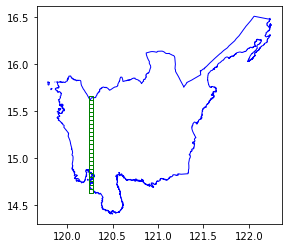

In [22]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k[grid_gdf5k["x"] == 10].plot(ax=ax, facecolor="none", edgecolor="green")

### Gridding at a coarser resolution
Let's try the same process but with a bigger grid (15K)

In [23]:
grid_generator15k = grids.SquareGridGenerator(15_000)  # 15 km x 15 km grids

Generate square grids
> Notice the time taken to grid the multi polygon at 15K resolution (compared to 5K resolution)


In [24]:
%%time
grid_gdf15k = grid_generator15k.generate_grid(region3_gdf)

CPU times: user 6.19 s, sys: 39.2 ms, total: 6.23 s
Wall time: 6.22 s


Show gridded version of sample geojson file at 15K resolution 

In [25]:
# hide_input
print(f"length of grid_gdf15k: {len(grid_gdf15k)} row(s)")

length of grid_gdf15k: 154 row(s)


In [26]:
# hide
assert len(grid_gdf15k) == 154

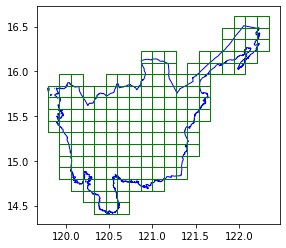

In [27]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")

### Reusing boundaries
If you have 2 polygons that are far from each other but wish to have them follow the reference same reference `x` and `y`, you can use pass in custom boudaries. 

Let's load some grids that are from each other

In [28]:
cell1 = grid_gdf15k.head(1)
cell2 = grid_gdf15k.tail(1)

In [29]:
pd.concat([cell1, cell2])

,x,y,geometry
7,0,7,"POLYGON ((119.78583 15.31919, 119.92058 15.319..."
322,18,16,"POLYGON ((122.21128 16.48548, 122.34603 16.485..."


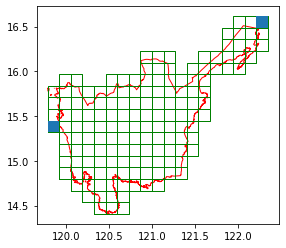

In [30]:
ax = region3_gdf.plot(facecolor="none", edgecolor="red")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")
ax = pd.concat([cell1, cell2]).plot(ax=ax)

In [31]:
grid_generator1k = grids.SquareGridGenerator(1_000, boundary=aoi_total_bounds)

In [32]:
%%time
gridcell1 = grid_generator1k.generate_grid(cell1)

CPU times: user 129 ms, sys: 30.1 ms, total: 159 ms
Wall time: 150 ms


In [33]:
len(gridcell1)

240

In [34]:
gridcell1.head()

,x,y,geometry
0,0,106,"POLYGON ((119.78583 15.32785, 119.79482 15.327..."
1,0,107,"POLYGON ((119.78583 15.33651, 119.79482 15.336..."
2,0,108,"POLYGON ((119.78583 15.34518, 119.79482 15.345..."
3,0,109,"POLYGON ((119.78583 15.35384, 119.79482 15.353..."
4,0,110,"POLYGON ((119.78583 15.36250, 119.79482 15.362..."


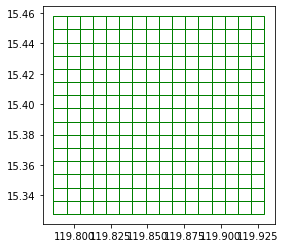

In [35]:
ax = gridcell1.plot(facecolor="none", edgecolor="green")

In [36]:
%%time
gridcell2 = grid_generator1k.generate_grid(cell2)

CPU times: user 54.6 ms, sys: 221 µs, total: 54.8 ms
Wall time: 52.5 ms


In [37]:
len(gridcell2)

12

In [38]:
gridcell2.head()

,x,y,geometry
0,270,240,"POLYGON ((122.21128 16.48548, 122.22027 16.485..."
1,270,241,"POLYGON ((122.21128 16.49409, 122.22027 16.494..."
2,270,242,"POLYGON ((122.21128 16.50270, 122.22027 16.502..."
3,271,240,"POLYGON ((122.22027 16.48548, 122.22925 16.485..."
4,271,241,"POLYGON ((122.22027 16.49409, 122.22925 16.494..."


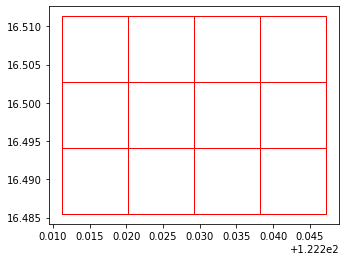

In [39]:
ax = gridcell2.plot(facecolor="none", edgecolor="red")

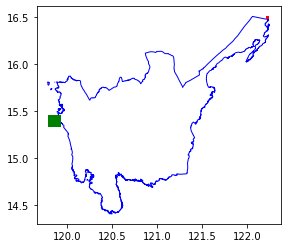

In [40]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = gridcell1.plot(ax=ax, color="green")
ax = gridcell2.plot(ax=ax, color="red")

## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, it might be better to use custom boundary and iterate througout each aoi 1 at a time.


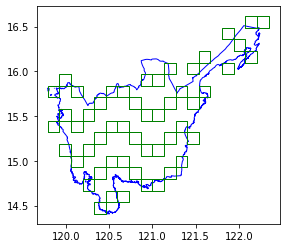

In [41]:
sparse_aois = grid_gdf15k.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green")

In [42]:
%%time
collection = []
for idx, area in sparse_aois.iterrows():  # Iterate through each aoi one at a time
    collection.append(
        grid_generator1k.generate_grid(
            gpd.GeoDataFrame(
                [area], crs=sparse_aois.crs  # Create a geodataframe with 1 row
            )
        )
    )
sparse_grid = pd.concat(collection)

CPU times: user 3.81 s, sys: 19.8 ms, total: 3.83 s
Wall time: 3.81 s


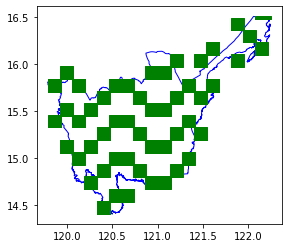

In [43]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

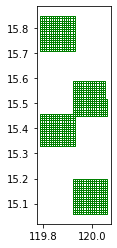

In [44]:
ax = sparse_grid.head(1000).plot(facecolor="none", edgecolor="green")

There might be some duplicates using this method if the aois area adjacent or near each other, you can remove the duplicates using the `x` and `y` columns. The combination of `x` and `y` will be unique as long as you pass in the same boundary and cell size.

In [45]:
len(sparse_grid[sparse_grid[["x", "y"]].duplicated()])  # count of duplicated xy rows

156

Final sparse grid with duplicate rows removed

In [46]:
final_sparse_grid = sparse_grid[~sparse_grid[["x", "y"]].duplicated()].reset_index()
len(final_sparse_grid)

12544

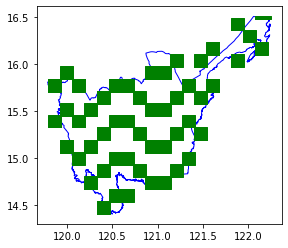

In [47]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = final_sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

## H3 Grid Generator
### Generating grids
Let us generate grids of resolution 5. To learn more about the different resolution, visit: https://h3geo.org/docs/core-library/restable/

In [48]:
h3_generator = grids.H3GridGenerator(resolution=5)

In [49]:
%%time
h3_5_gdf = h3_generator.generate_grid(region3_gdf)

CPU times: user 4.46 s, sys: 19.3 ms, total: 4.48 s
Wall time: 4.47 s


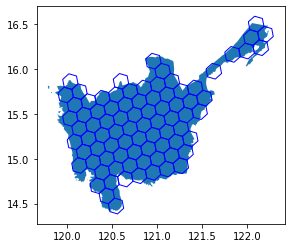

In [50]:
ax = region3_gdf.plot(aspect="equal")
ax = h3_5_gdf.plot(ax=ax, facecolor="none", edgecolor="blue", aspect="equal")

## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, H3 grid generator already handles optmizig this

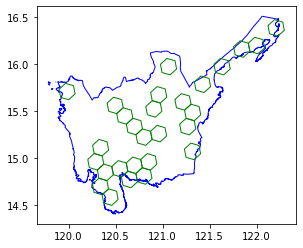

In [51]:
sparse_aois = h3_5_gdf.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot(facecolor="none", edgecolor="blue", aspect="equal")
ax = sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green", aspect="equal")

In [52]:
h3_generator_high_res = grids.H3GridGenerator(resolution=8)

In [53]:
%%time
h3_8_gdf = h3_generator_high_res.generate_grid(sparse_aois)

CPU times: user 748 ms, sys: 10.2 ms, total: 759 ms
Wall time: 757 ms


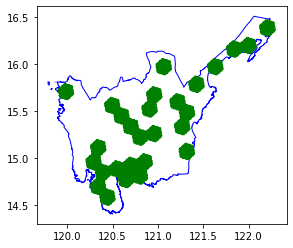

In [54]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = h3_8_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

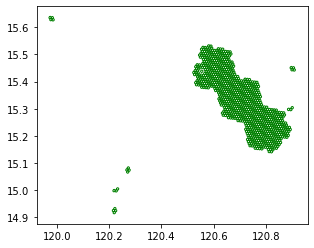

In [55]:
ax = h3_8_gdf.sort_values("hex_id").head(1000).plot(facecolor="none", edgecolor="green")

### Not exporting geometry
If you do not plan to use use geometry, you can pass `return_geometry=False` to just get a normal pandas DataFrame with the ids.

In [56]:
h3_generator_no_geom = grids.H3GridGenerator(resolution=5, return_geometry=False)

In [57]:
%%time
h3_region3_no_geom = h3_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 3.82 s, sys: 38.8 ms, total: 3.86 s
Wall time: 3.85 s


In [58]:
len(h3_region3_no_geom)

84

In [59]:
h3_region3_no_geom.head()

,hex_id
0,856943b7fffffff
1,85696b47fffffff
2,85694cc7fffffff
3,85694cdbfffffff
4,856941cbfffffff


## Bing Tile Grid Generator
### Generating grids
Let us generate grids of zoom_level 12. To learn more about the different resolution, visit: https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system

In [60]:
bing_tile_grid_generator = grids.BingTileGridGenerator(12)

In [61]:
%%time
# slow
bing_tile_gdf = bing_tile_grid_generator.generate_grid(region3_gdf)

CPU times: user 10.4 s, sys: 16 ms, total: 10.4 s
Wall time: 10.4 s


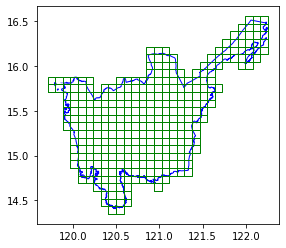

In [62]:
# no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

### Not exporting geometry

If you do not plan to use use geometry, you can pass return_geometry=False to just get a normal pandas DataFrame with the ids.


In [63]:
bing_tile_grid_generator_no_geom = grids.BingTileGridGenerator(
    12, return_geometry=False
)

In [64]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 9.67 s, sys: 37.3 ms, total: 9.7 s
Wall time: 9.71 s


In [65]:
# no_test
bing_region3_keys.head()

,quadkey
0,132303030330
1,132303030331
2,132303030313
3,132303012302
4,132303012031
